In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 111.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.9 MB/s eta 0:00:00


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import_bert_tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [4]:
bert_model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

## Collecting the reviews using Beautiful soup form yelp website of 14 pages reviews

In [5]:
reviews = ""
i = 10
while i <= 140:
  page_reviews = requests.get(f'https://www.yelp.com/biz/social-brew-cafe-pyrmont?start={i}')
  reviews += page_reviews.text
  i+=10

##Extracting 1st 100 characters from the string reviews

In [8]:
reviews[0:100]

'<!DOCTYPE html><html lang="en-US" prefix="og: http://ogp.me/ns#" style="margin: 0;padding: 0; border'

In [9]:
len(reviews)

17099414

In [10]:
soup = BeautifulSoup(reviews, 'html.parser')
regex = re.compile('.*comment.*')
results = soup.find_all('p', {'class':regex})
customer_reviews = [result.text for result in results]

In [11]:
customer_reviews[0]

"It was ok. The coffee wasn't the best but it was fine. The relish on the breakfast roll was yum which did make it sing. So perhaps I just got a bad coffee but the food was good on my visit."

In [13]:
reviews_data = pd.DataFrame(np.array(customer_reviews),columns=['reviews'])

In [14]:
reviews_data.sample(5)

,reviews
126,Dropped by here for a bite since it started to...
100,"Oh My, a foodie from San Diego. Wow what a fin..."
120,"Whilst I enjoyed this place, I can't seem unde..."
118,We were looking for a late brunch spot with bo...
94,Love this place - food was good service was ex...


In [15]:
reviews_data.shape

(133, 1)

In [16]:
def sentiment_analysis(review):
  tokens = import_bert_tokenizer.encode(review,return_tensors='pt')
  result = bert_model(tokens)
  return int(torch.argmax(result.logits)) + 1

In [17]:
reviews_data['sentimental_score'] = reviews_data['reviews'].apply(lambda x : sentiment_analysis(x[:512]))


In [18]:
reviews_data.head()

,reviews,sentimental_score
0,It was ok. The coffee wasn't the best but it w...,3
1,This place is a gem. The ambiance is to die fo...,3
2,I went here a little while ago- a beautiful mo...,2
3,Ron & Jo are on the go down under and Wow! We...,5
4,5 stars all around for the staff and delicious...,5


In [19]:
def sentimental_string_score(reviews):
  if reviews >= 4:
    return 'POSITIVE REVIEW'
  elif reviews == 3:
    return 'NEUTRAL REVIEW'
  else :
    return 'NEGATIVE REVIEW'
reviews_data['sentimental_string_score'] = reviews_data['sentimental_score'].apply(sentimental_string_score)

In [20]:
reviews_data.sample(5)

,reviews,sentimental_score,sentimental_string_score
25,"Two gooey, bacon filled, oozing brekkie rolls....",1,NEGATIVE REVIEW
109,This was the first restaurant we ate at upon f...,5,POSITIVE REVIEW
70,This place was just what we wanted- simple men...,5,POSITIVE REVIEW
29,The foood is VERY goood! I had a steak sandwic...,2,NEGATIVE REVIEW
47,Great atmosphere. Food perfect to rejuvenate a...,5,POSITIVE REVIEW


In [21]:
reviews_data['sentimental_score'].value_counts()

5    84
4    30
3     9
2     5
1     5
Name: sentimental_score, dtype: int64

In [22]:
reviews_data['sentimental_string_score'].value_counts()

POSITIVE REVIEW    114
NEGATIVE REVIEW     10
NEUTRAL REVIEW       9
Name: sentimental_string_score, dtype: int64

<ipython-input-23-226fd3579b70>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  reviews_data.groupby(['sentimental_string_score']).sum().plot(kind='pie', y='sentimental_score', autopct='%1.0f%%',


<Axes: title={'center': 'Reviews Given By The Customers'}, ylabel='sentimental_score'>

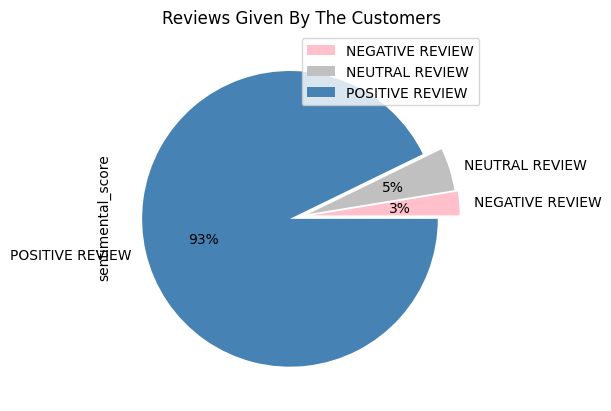

In [23]:
colors = ['pink', 'silver', 'steelblue']
explode = (0.07, 0.05, 0.08)
reviews_data.groupby(['sentimental_string_score']).sum().plot(kind='pie', y='sentimental_score', autopct='%1.0f%%',
                                colors = colors, explode=explode,
                                title='Reviews Given By The Customers')

#### Conclusion : Tha data is extracted form yelp website using beautifulsoup, the sentimental score of the extracted reviews are generated using pretrained bert model the majority i.e 93%  reviews given by the customers are positive and only 3% of the customers gave bad reviews and 5% of the custmoners are just satisfied with the food and restaurant